## Single Sensor Network Simulation

### **Purpose of the Notebook**
This Jupyter Notebook serves as a proof of concept for simulating a single-sensor network that monitors temperature data over a spatial grid. The experiment evaluates temperature data captured at **randomly selected grid points** and transmitted to a **central hub**. The sensor reports hourly temperature readings, allowing for further analysis of:

1. **Data Volume**: The total amount of data transmitted by the sensor.
2. **Resource Efficiency**: A measure of the distance traveled per byte of data transmitted.
3. **Temperature Trends**: Visualizing temporal temperature changes at the sensor location.

### **Key Steps in the Notebook**
1. **Dataset Loading**: Temperature data from NetCDF format is loaded and converted to Celsius.
2. **Sensor Simulation**: A sensor is placed randomly on the grid, continuously reporting temperature values.
3. **Central Hub Positioning**: A fixed central location is defined to act as the sensor's reporting hub.
4. **Visualization**:
   - Plot of the temperature grid with sensor and hub locations.
   - Line plot of temperature readings over time at the sensor's location.
5. **Efficiency Analysis**:
   - Calculate data volume (bytes transferred).
   - Compute resource efficiency (distance per byte traveled).
6. **Reporting**: Output a summary report of sensor performance and resource usage.

### **Input Data**
- **Temperature Data**: ERA5-derived temperature grids in NetCDF format.
- **Spatial Resolution**: Latitude (14x14 grid) and Longitude coordinates.
- **Temporal Resolution**: Hourly readings spanning multiple days.

### **Outputs**
- Temperature grid plots showcasing sensor and hub locations.
- A time series plot of the temperature at the sensor location.
- A summary report detailing sensor efficiency and data transfer volume.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import random
import xarray as xr
from math import radians, cos, sin, sqrt, atan2

In [2]:
# Load the NetCDF data file
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed
ds = xr.open_dataset(file_path)

# Convert temperature to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Step 1: Select Random Sensor Location
# Get unique latitude and longitude values
latitudes = ds["latitude"].values
longitudes = ds["longitude"].values

# Randomly choose a grid cell
random_lat = random.choice(latitudes)
random_lon = random.choice(longitudes)
print(f"Random Sensor Location: Latitude = {random_lat}, Longitude = {random_lon}")

# Step 2: Extract Temperature Data for the Sensor Location
sensor_data = ds["t2m_celsius"].sel(latitude=random_lat, longitude=random_lon)

# Convert the data to a Pandas DataFrame for easier processing
sensor_df = sensor_data.to_dataframe().reset_index()

# Filter to keep only valid_time and temperature
sensor_df = sensor_df[["valid_time", "t2m_celsius"]]
sensor_df.rename(columns={"t2m_celsius": "temperature_c"}, inplace=True)

# Step 3: Simulate Sensor Reporting Every Hour
# Simulate reporting by saving the data to a CSV file
output_file = "../data/sensor_report_single_sensor.csv"
sensor_df.to_csv(output_file, index=False)

print(f"Sensor data saved to: {output_file}")

# Step 4: Preview the Data
print("Sensor Report (First 5 Rows):")
print(sensor_df.head())


Random Sensor Location: Latitude = 56.249999999999986, Longitude = -110.85000000000007
Sensor data saved to: ../data/sensor_report_single_sensor.csv
Sensor Report (First 5 Rows):
           valid_time  temperature_c
0 2016-04-30 00:00:00      17.875824
1 2016-04-30 01:00:00      17.075409
2 2016-04-30 02:00:00      15.290985
3 2016-04-30 03:00:00      12.948273
4 2016-04-30 04:00:00      11.430084


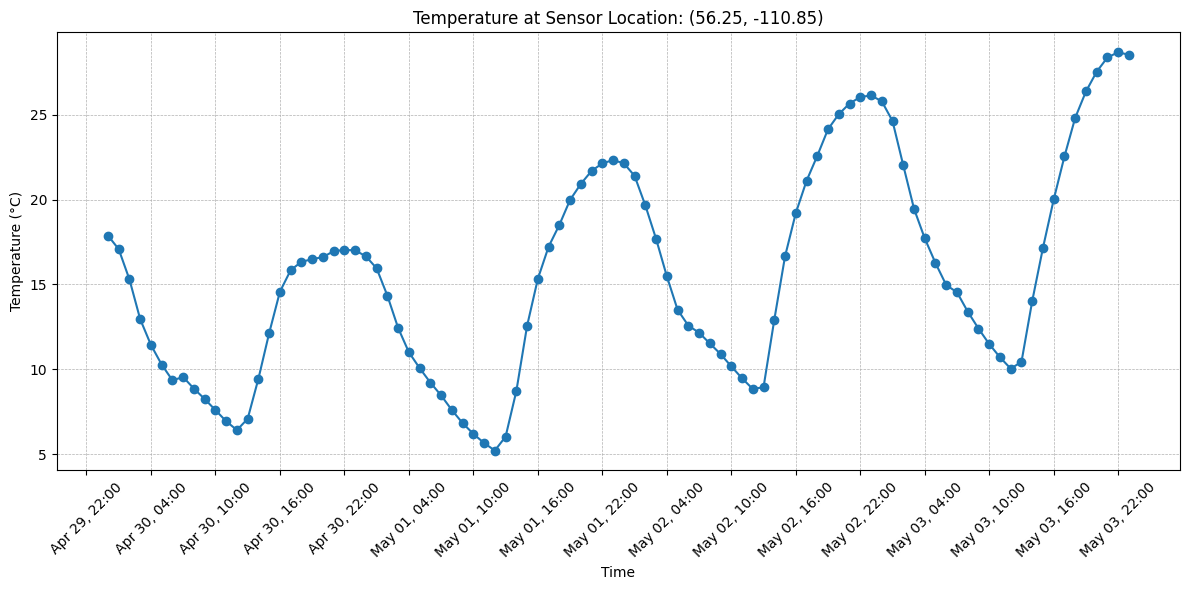

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the temperature over time
plt.figure(figsize=(12, 6))
plt.plot(sensor_df["valid_time"], sensor_df["temperature_c"], marker="o", linestyle="-", color="tab:blue")
plt.title(f"Temperature at Sensor Location: ({random_lat:.2f}, {random_lon:.2f})")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))  # Format time
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Major ticks every 6 hours
plt.xticks(rotation=45)
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [4]:
# Haversine formula to compute distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2.0)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2.0)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Assume the central hub is at the center of the grid
central_lat, central_lon = 56.7, -111.4  # Replace with the actual central point

# Calculate distance from sensor to hub
distance_to_hub = haversine(random_lat, random_lon, central_lat, central_lon)
print(f"Distance from Sensor to Central Hub: {distance_to_hub:.2f} km")

Distance from Sensor to Central Hub: 60.37 km


In [5]:
# Step 1: Data Volume
num_readings = len(sensor_df)
bytes_per_reading = 4  # Float32 value (4 bytes per temperature reading)
data_volume_bytes = num_readings * bytes_per_reading

# Step 2: Resource Efficiency
# Resource efficiency = Distance per byte transferred (in km/byte)
efficiency = distance_to_hub / data_volume_bytes

# Step 3: Report Summary
report = {
    "Sensor Location": f"Latitude: {random_lat}, Longitude: {random_lon}",
    "Total Readings": num_readings,
    "Data Volume (Bytes)": data_volume_bytes,
    "Distance to Hub (km)": round(distance_to_hub, 2),
    "Resource Efficiency (km/Byte)": round(efficiency, 6)
}

# Display the Report
for key, value in report.items():
    print(f"{key}: {value}")


Sensor Location: Latitude: 56.249999999999986, Longitude: -110.85000000000007
Total Readings: 96
Data Volume (Bytes): 384
Distance to Hub (km): 60.37
Resource Efficiency (km/Byte): 0.157215


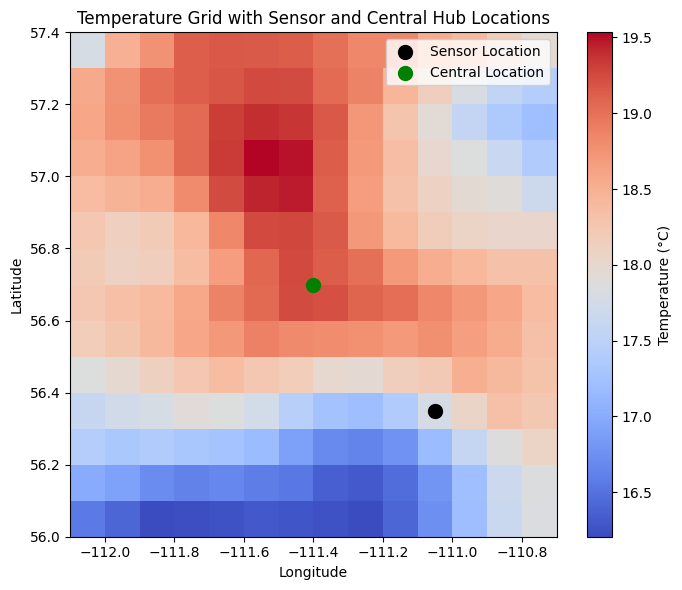

In [6]:
first_grid = ds["t2m_celsius"].isel(valid_time=0)

# Define Sensor Location (replace with values if random)
random_lat = 56.35  # Random latitude
random_lon = -111.05  # Random longitude

# Plot the temperature grid
plt.figure(figsize=(7, 6))
plt.pcolormesh(
    ds["longitude"], ds["latitude"], first_grid,
    cmap="coolwarm", shading="auto"
)
plt.colorbar(label="Temperature (°C)")

# Mark the Sensor's Location
plt.scatter(random_lon, random_lat, color="black", s=100, label="Sensor Location")
#plt.annotate("Sensor", xy=(random_lon, random_lat), xytext=(random_lon - 0.05, random_lat - 0.05),
#             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color="black")

# Mark the Central Location
plt.scatter(central_lon, central_lat, color="green", s=100, label="Central Location")
#plt.annotate("Central Hub", xy=(central_lon, central_lat), xytext=(central_lon + 0.05, central_lat + 0.05),
#             arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color="green")

# Add Titles and Labels
plt.title("Temperature Grid with Sensor and Central Hub Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()
